In [1]:
# config
import sys
import numpy as np
import torch
assert torch.cuda.is_available()
%matplotlib inline
cuda_device = torch.device("cuda:0")
torch.cuda.set_device(cuda_device)
from config import config
setting = config(
    cuda_device, 
    model_save_name="/home/zzn/PycharmProjects/RESNET_FPN/StateDicts/DOMAIN_ADA_AplusB_7_13.pkl", 
    dataset_name="SHA",
    lr=1e-4, 
    batch_size=5, 
    eval_per_step=120
)
setting_B = config(
    cuda_device, 
    dataset_name="SHB",
)

In [2]:
# data_load
from Dataset.DatasetConstructor import TrainDatasetConstructor,EvalDatasetConstructor
train_dataset_A = TrainDatasetConstructor(setting.train_num, setting.train_img_path, setting.train_gt_map_path, 
                                          setting.train_pers_path, mode=setting.mode, dataset_name=setting.dataset_name, 
                                          device=setting.cuda_device, 
                                          if_random_hsi=setting.if_random_hsi, if_flip=setting.if_random_hsi)
eval_dataset = EvalDatasetConstructor(setting.eval_num, setting.eval_img_path, setting.eval_gt_map_path, 
                                      setting.eval_pers_path, mode=setting.mode, dataset_name=setting.dataset_name, 
                                      device=setting.cuda_device)
train_dataset_B = TrainDatasetConstructor(setting_B.train_num, setting_B.train_img_path, setting_B.train_gt_map_path, 
                                          setting_B.train_pers_path, mode=setting_B.mode, dataset_name=setting_B.dataset_name, 
                                          device=setting_B.cuda_device, 
                                          if_random_hsi=setting_B.if_random_hsi, if_flip=setting_B.if_random_hsi)
train_loader_A = torch.utils.data.DataLoader(dataset=train_dataset_A, batch_size=setting.train_batch_size)
train_loader_B = torch.utils.data.DataLoader(dataset=train_dataset_B, batch_size=setting.train_batch_size)
eval_loader = torch.utils.data.DataLoader(dataset=eval_dataset, batch_size=1)

In [3]:
# model construct
from net.RES_FPN.FPN import FPN
from net.RES_FPN.Discriminator import Discriminator
from eval.Estimator import Estimator
net = FPN().to(setting.cuda_device)
D = Discriminator().to(setting.cuda_device)
G, decoder = net.getEncoder(), net.getDecoder()

optimizer = torch.optim.Adam(net.parameters(), setting.learning_rate)
optimizerD = torch.optim.Adam(D.parameters(), setting.learning_rate)
optimizerG = torch.optim.Adam(G.parameters(), setting.learning_rate)

criterion = torch.nn.MSELoss(reduction='sum').to(setting.cuda_device)
criterionGAN = torch.nn.BCELoss().to(setting.cuda_device)

estimator = Estimator(setting, eval_loader, criterion=criterion)

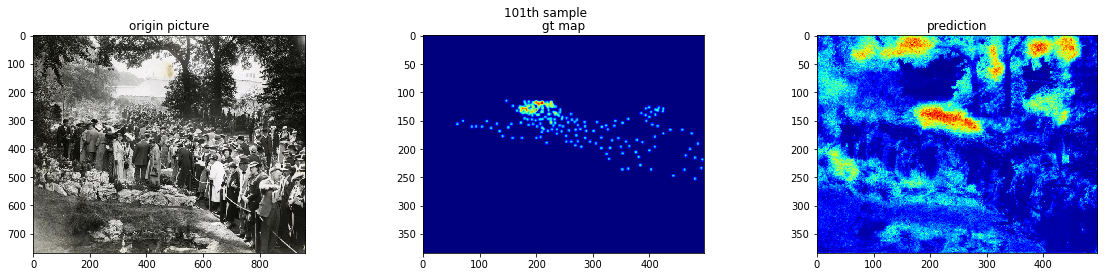

The gt counts of the above sample:211, and the pred counts:817.9401245117188
In step 120, epoch 1, loss = 12.576733089410341, eval_mae = 196.8856201171875, eval_rmse = 301.8584899902344, time cost eval = 31.09557580947876s


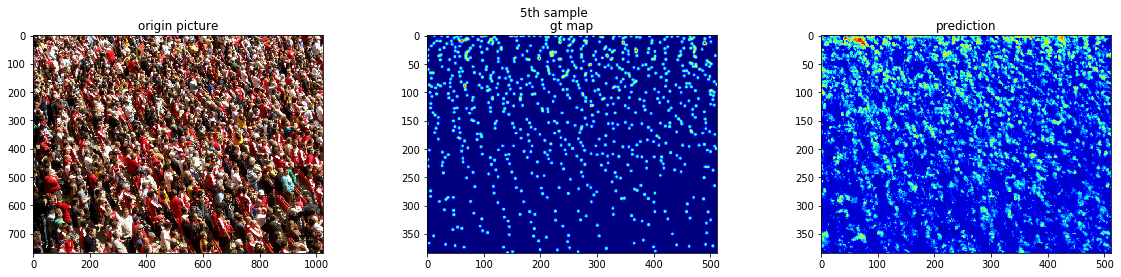

The gt counts of the above sample:819, and the pred counts:391.2024841308594
In step 240, epoch 2, loss = 11.283399776443021, eval_mae = 211.47850036621094, eval_rmse = 319.0296325683594, time cost eval = 31.091266870498657s


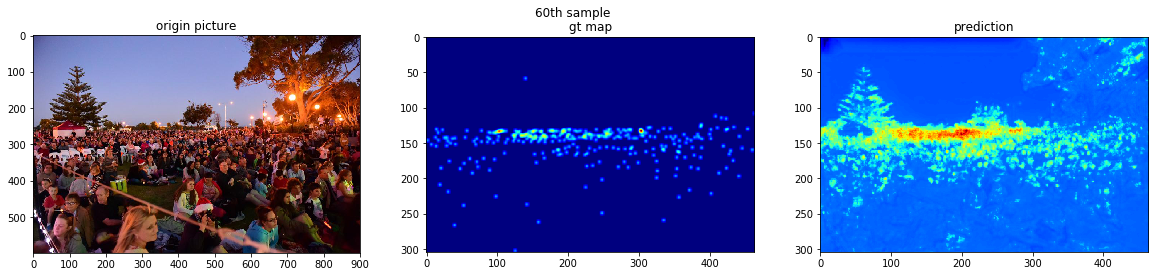

The gt counts of the above sample:293, and the pred counts:123.41569519042969
In step 360, epoch 3, loss = 12.461248613320864, eval_mae = 337.5085754394531, eval_rmse = 493.0909729003906, time cost eval = 31.06413173675537s


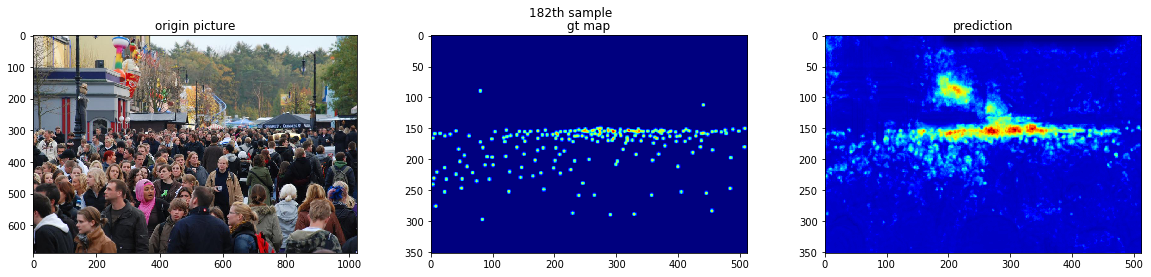

The gt counts of the above sample:199, and the pred counts:345.28125
In step 480, epoch 4, loss = 13.786162884025783, eval_mae = 440.3141784667969, eval_rmse = 597.0978393554688, time cost eval = 31.08696460723877s


In [ ]:
import time
step = 0
eval_loss, eval_mae, eval_rmse = [], [], []
real_label = torch.ones(setting.train_batch_size, 1).to(setting.cuda_device)
fake_label = torch.zeros(setting.train_batch_size, 1).to(setting.cuda_device)
for epoch_index in range(setting.epoch):
    train_dataset_A.shuffle()
    train_dataset_B.shuffle()
    loss_list = []
    time_per_epoch = 0
    for A_items, B_items in zip(train_loader_A, train_loader_B):
        if step % setting.eval_per_step == 0 and step > 0:
            validate_MAE, validate_RMSE, validate_loss, time_cost = estimator.evaluate(net, True)
            eval_loss.append(validate_loss)
            eval_mae.append(validate_MAE)
            eval_rmse.append(eval_rmse)
            sys.stdout.write(
                'In step {}, epoch {}, loss = {}, eval_mae = {}, eval_rmse = {}, time cost eval = {}s\n'
                .format(step, epoch_index, validate_loss, validate_MAE,
                        validate_RMSE, time_cost))
            sys.stdout.flush()
            #   save model
            if setting.min_mae > validate_MAE:
                setting.min_mae = validate_MAE
                torch.save(net.state_dict(), setting.model_save_path)
        
        net.train()
        torch.cuda.empty_cache()
        (A_img_index, A_x, A_gt, A_pers), (B_img_index, B_x, B_gt, B_pers) = A_items, B_items
        fake_h_1, _, _ , _= G(B_x)
        fake_y = D(fake_h_1)
        gan_G_loss = criterionGAN(fake_y, real_label)
        optimizerG.zero_grad()
        gan_G_loss.backward()
        optimizerG.step()
        
        with torch.no_grad():
            real_h_1, _, _ , _= G(A_x)
            fake_h_1, _, _ , _= G(B_x)
        real_y = D(real_h_1)
        gan_real_loss = criterionGAN(real_y, real_label)
        fake_y = D(fake_h_1)
        gan_fake_loss = criterionGAN(fake_y, fake_label)
        gan_D_loss = (gan_real_loss + gan_fake_loss) * 0.5
        optimizerD.zero_grad()
        gan_D_loss.backward()
        optimizerD.step()
        
        real_out = net(A_x, A_pers)
        l2_loss = criterion(real_out, A_gt)
        optimizer.zero_grad()
        l2_loss.backward()
        optimizer.step()
        
        fake_out = net(B_x, B_pers)
        l2_loss = criterion(fake_out, B_gt)
        optimizer.zero_grad()
        l2_loss.backward()
        optimizer.step()
        step += 2